In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string

from string import punctuation
from mlxtend.frequent_patterns import association_rules, apriori
from openpyxl import Workbook
import warnings
warnings.filterwarnings("ignore")

## Data loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
products = pd.read_excel('/content/drive/MyDrive/olist_products_dataset.xlsx')
iteams = pd.read_csv('/content/drive/MyDrive/olist_order_items_dataset.csv')
order = pd.read_csv('/content/drive/MyDrive/olist_orders_dataset.csv')
reviews_data = pd.read_excel('/content/drive/MyDrive/olist_order_reviews_dataset_English.xlsx')

## Data preprocessing

#### Table merge

In [4]:
merged_df = pd.merge(iteams,products[['product_id','product_category_name']],on='product_id')

In [5]:
merged_df = pd.merge(merged_df, order, on='order_id')

In [6]:
merged_df.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date'],
      dtype='object')

#### Convert date format

In [7]:
merged_df['order_purchase_timestamp'] = pd.to_datetime(merged_df['order_purchase_timestamp'])

In [8]:
# Extracting date
merged_df['date'] = merged_df['order_purchase_timestamp'].dt.date

#Extracting time
merged_df['time'] = merged_df['order_purchase_timestamp'].dt.time

# Extracting month and replacing it with text
merged_df['month'] = merged_df['order_purchase_timestamp'].dt.month
merged_df['month'] = merged_df['month'].replace((1,2,3,4,5,6,7,8,9,10,11,12),
                                          ('January','February','March','April','May','June','July','August',
                                          'September','October','November','December'))

# Extracting hour
merged_df['hour'] = merged_df['order_purchase_timestamp'].dt.hour
# Replacing hours with text
hour_in_num = (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23)
hour_in_obj = ('1-2','2-3','3-4','4-5','5-6','6-7','7-8','8-9','9-10','10-11','11-12','12-13','13-14','14-15',
               '15-16','16-17','17-18','18-19','19-20','20-21','21-22','22-23','23-24')
merged_df['hour'] = merged_df['hour'].replace(hour_in_num, hour_in_obj)

# Extracting weekday and replacing it with text
merged_df['weekday'] = merged_df['order_purchase_timestamp'].dt.weekday
merged_df['weekday'] = merged_df['weekday'].replace((0,1,2,3,4,5,6),
                                          ('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'))
# dropping date_time column
merged_df.drop('order_purchase_timestamp',axis=1,inplace=True)

In [9]:
# 假设 time 列已经是 datetime 类型
def categorize_time(time):
    hour = time.hour
    if 8 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    else:
        return 'night'

merged_df['time_period'] = merged_df['time'].apply(categorize_time)

# 现在你可以查看或者分析分好类的时间段了
result_df = merged_df[['order_id', 'product_category_name', 'time_period', 'time','month', 'date','weekday']]

In [10]:
result_df['date'] = pd.to_datetime(result_df['date'])

In [11]:
result_df['year_month'] = result_df['date'].dt.strftime('%Y-%m')

In [12]:
result_df.head(5)

,order_id,product_category_name,time_period,time,month,date,weekday,year_month
0,00010242fe8c5a6d1ba2dd792cb16214,cool_stuff,morning,08:59:02,September,2017-09-13,Wednesday,2017-09
1,130898c0987d1801452a8ed92a670612,cool_stuff,morning,11:52:20,June,2017-06-28,Wednesday,2017-06
2,532ed5e14e24ae1f0d735b91524b98b9,cool_stuff,morning,10:25:53,May,2018-05-18,Friday,2018-05
3,6f8c31653edb8c83e1a739408b5ff750,cool_stuff,night,18:38:42,August,2017-08-01,Tuesday,2017-08
4,7d19f4ef4d04461989632411b7e588b9,cool_stuff,night,21:48:40,August,2017-08-10,Thursday,2017-08


## Data analysis

#### Best Selling Items

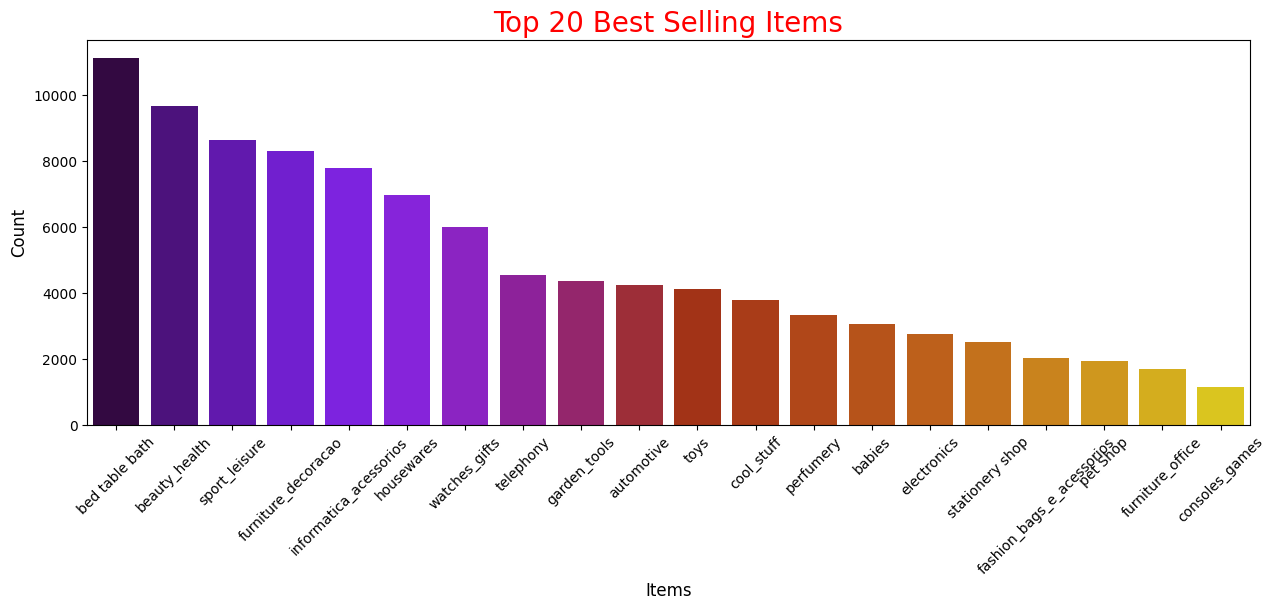

In [13]:
plt.figure(figsize=(15,5))
sns.barplot(x = result_df.product_category_name.value_counts().head(20).index, y = result_df.product_category_name.value_counts().head(20).values, palette = 'gnuplot')
plt.xlabel('Items', size = 12)
plt.xticks(rotation=45)
plt.ylabel('Count', size = 12)
plt.title('Top 20 Best Selling Items', color = 'Red', size = 20)
plt.show()

#### Number of orders received each month

In [14]:
order_moth_count = result_df[['order_id','year_month']].groupby('year_month').count()

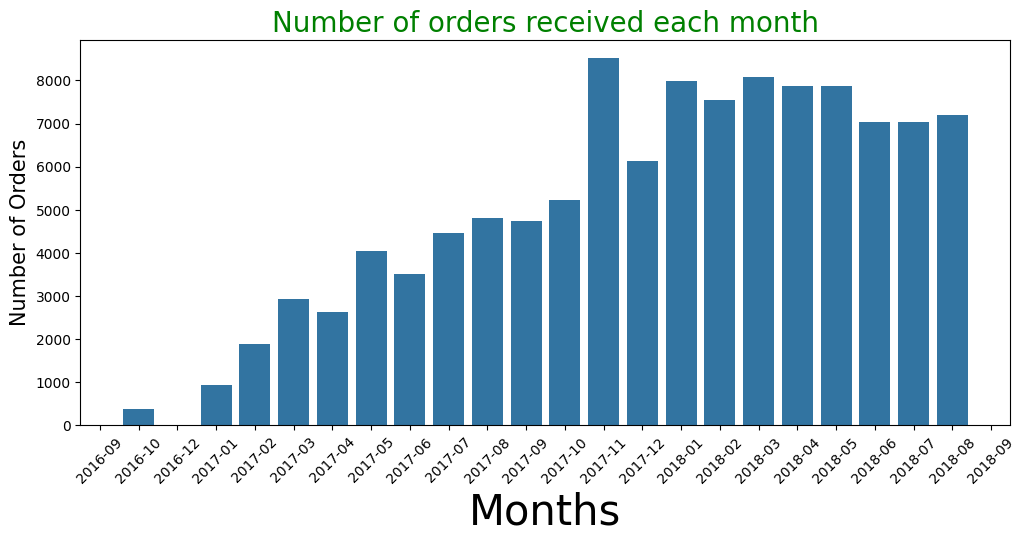

In [15]:
plt.figure(figsize=(12,5))
sns.barplot(data = order_moth_count, x = "year_month", y = "order_id")
plt.xlabel('Months', size = 30)
plt.ylabel('Number of Orders', size = 15)
plt.xticks(rotation=45)
plt.title('Number of orders received each month', color = 'green', size = 20)
plt.show()

#### Number of oders received each time period

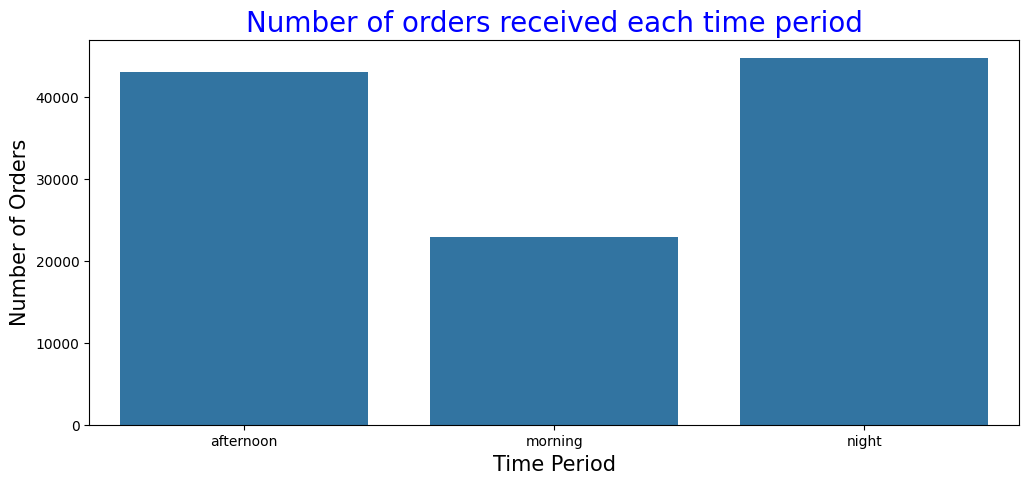

In [16]:
timeTran = result_df.groupby('time_period')['order_id'].count().reset_index()

plt.figure(figsize=(12,5))
sns.barplot(data = timeTran, x = "time_period", y = "order_id")
plt.xlabel('Time Period', size = 15)
plt.ylabel('Number of Orders', size = 15)
plt.title('Number of orders received each time period', color = 'blue', size = 20)
plt.show()


plt.show()

#### Number of oders received each day

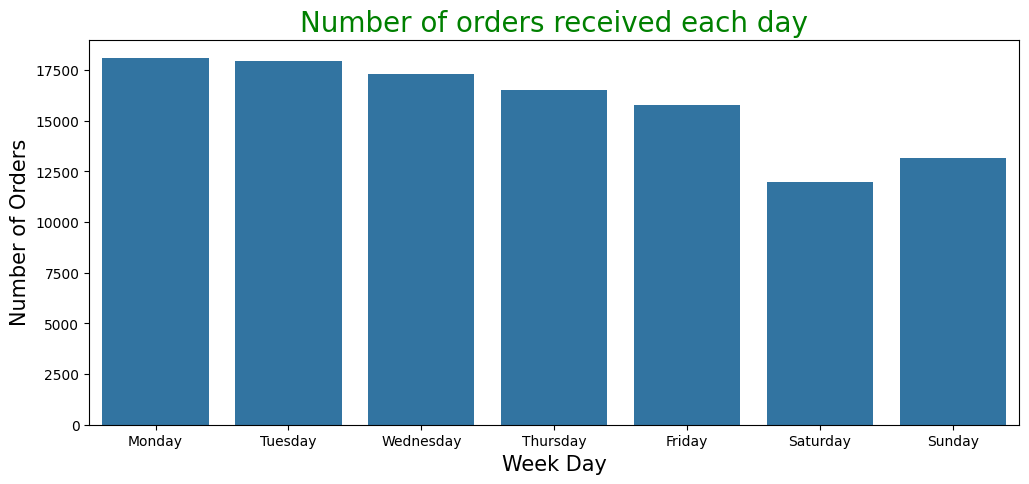

In [17]:
weekTran = result_df.groupby('weekday')['order_id'].count().reset_index()
weekTran.loc[:,"weekorder"] = [4,0,5,6,3,1,2]
weekTran.sort_values("weekorder",inplace=True)

plt.figure(figsize=(12,5))
sns.barplot(data = weekTran, x = "weekday", y = "order_id")
plt.xlabel('Week Day', size = 15)
plt.ylabel('Number of Orders', size = 15)
plt.title('Number of orders received each day', color = 'green', size = 20)
plt.show()


plt.show()

#### Best-selling products in different time periods

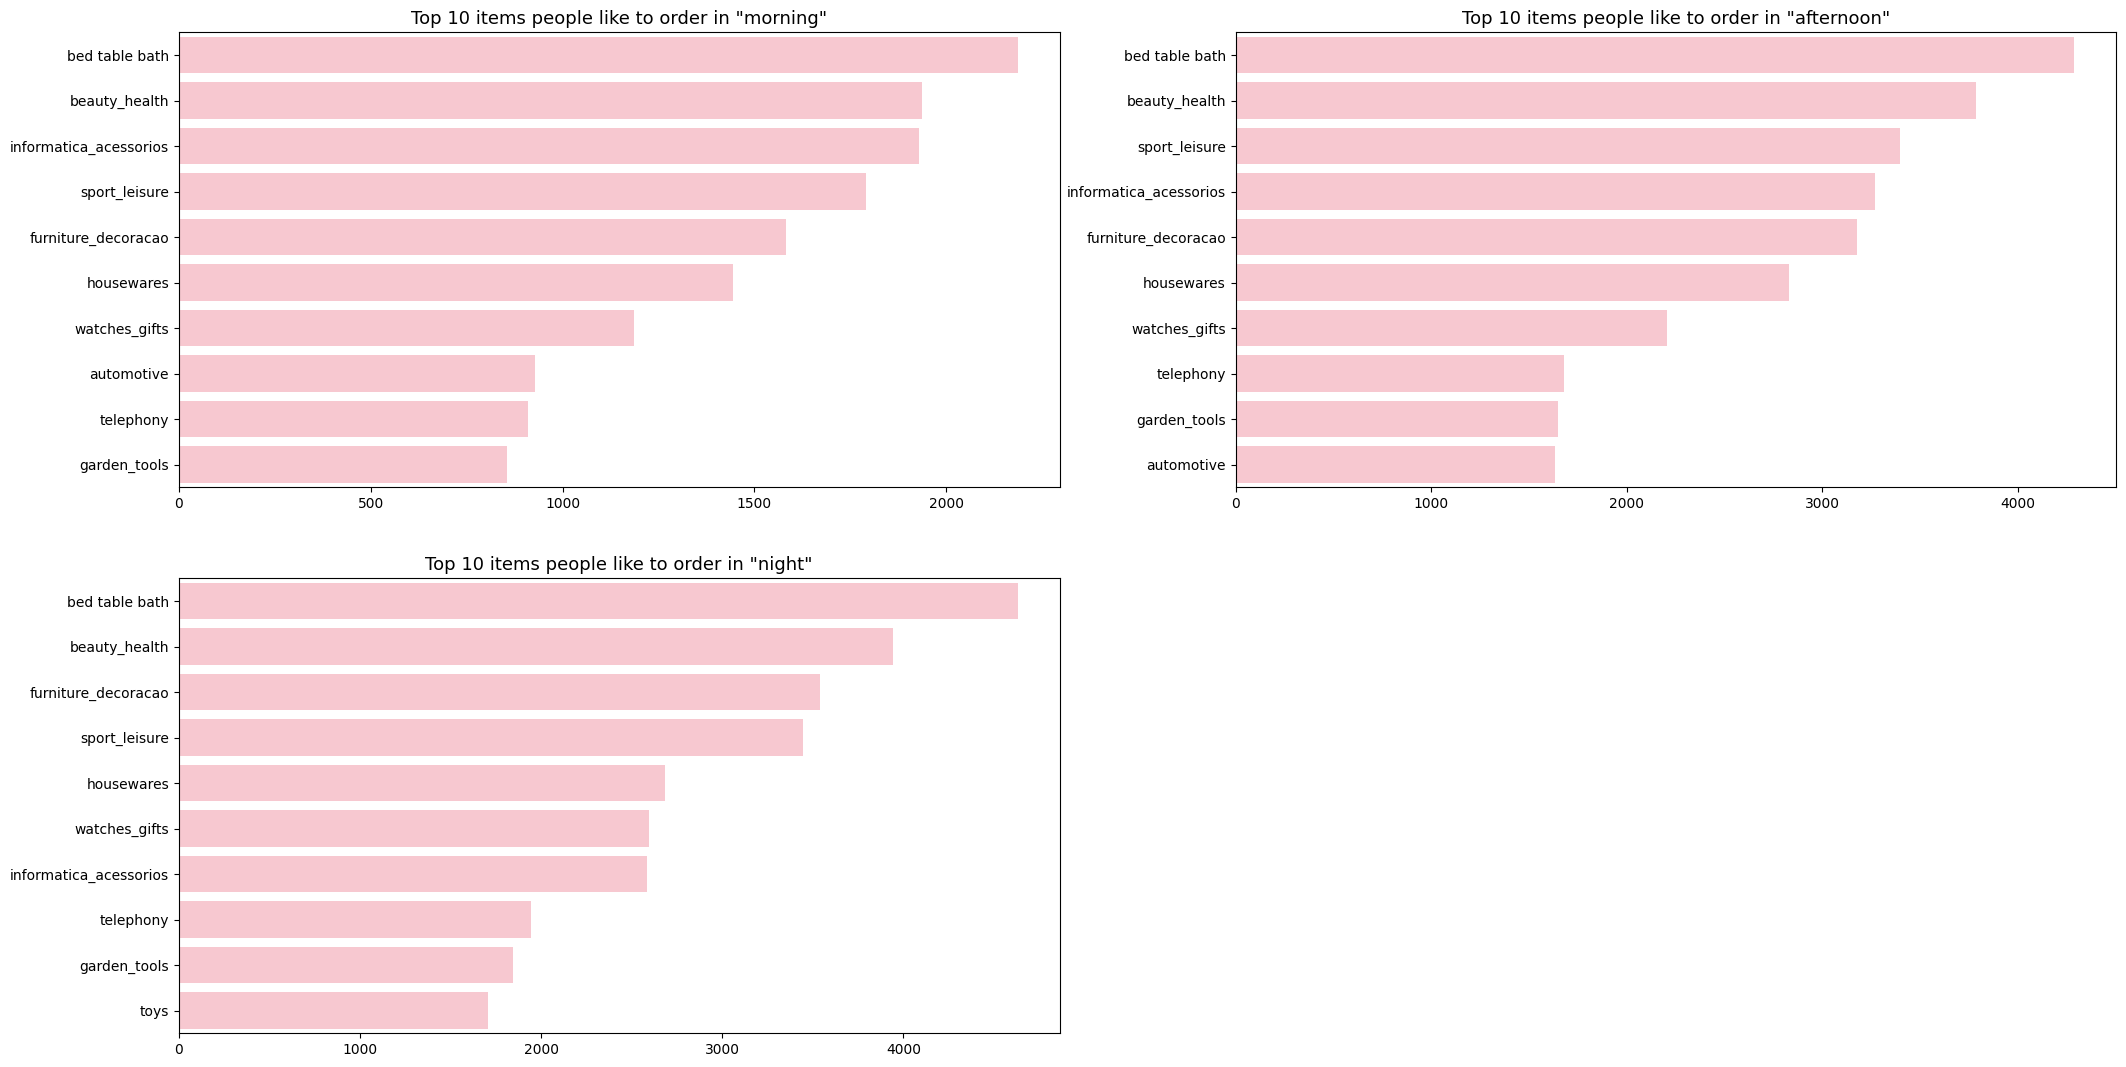

In [18]:
data = result_df.groupby(['time_period','product_category_name'])['order_id'].count().reset_index().sort_values(['time_period','order_id'],ascending=False)
day = ['morning','afternoon','night']

plt.figure(figsize=(25,13))
for i,j in enumerate(day):
    plt.subplot(2,2,i+1)
    df1 = data[data.time_period==j].head(10)
    sns.barplot(data=df1, y=df1.product_category_name, x=df1.order_id, color='pink')
    plt.xlabel('')
    plt.ylabel('')
    plt.title('Top 10 items people like to order in "{}"'.format(j), size=13)

plt.show()

## Association Rules Mining

In [19]:
transactions_str = result_df.groupby(['order_id', 'product_category_name'])['product_category_name'].count().reset_index(name ='Quantity')
transactions_str.head(5)

,order_id,product_category_name,Quantity
0,00010242fe8c5a6d1ba2dd792cb16214,cool_stuff,1
1,00018f77f2f0320c557190d7a144bdd3,pet Shop,1
2,000229ec398224ef6ca0657da4fc703e,furniture_decoracao,1
3,00024acbcdf0a6daa1e931b038114c75,perfumery,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,garden_tools,1


In [20]:
df_matrix = transactions_str.pivot_table(index='order_id', columns='product_category_name', values='Quantity', aggfunc='sum').fillna(0)
df_matrix.head(5)

product_category_name,Art,Christmas articles,agro_industria_e_commerce,air conditioning,arts_and_crafts,audio,automotive,babies,bags_accessories,beauty_health,...,portateis_kitchen_e_food_preparators,signaling_and_safety,sport_leisure,stationery shop,tablets_impressao_imagem,technical books,telephony,toys,watches_gifts,women's_fashion_clothes
order_id,,,,,,,,,,,,,,,,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00018f77f2f0320c557190d7a144bdd3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000229ec398224ef6ca0657da4fc703e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00024acbcdf0a6daa1e931b038114c75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00042b26cf59d7ce69dfabb4e55b4fd9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
df_matrix[df_matrix>1]=1

In [59]:
frequent_items = apriori(df_matrix, min_support = 0.00001,use_colnames = True)
frequent_items_sort= frequent_items.sort_values(by='support', ascending=False)
frequent_items_sort #toooooooooooooooooooooooooo small

,support,itemsets
10,0.096967,(bed table bath)
9,0.091000,(beauty_health)
65,0.079478,(sport_leisure)
50,0.068585,(informatica_acessorios)
38,0.066153,(furniture_decoracao)
...,...,...
187,0.000010,"(construction_tools_construction, pet Shop)"
188,0.000010,"(construction_tools_construction, toys)"
189,0.000010,"(watches_gifts, construction_tools_construction)"
190,0.000010,"(construction_tools_lighting, construction_too..."


In [23]:
merged_df.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'customer_id', 'order_status',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'date', 'time', 'month', 'hour', 'weekday', 'time_period'],
      dtype='object')

#### Result

In [63]:
transactions_str = merged_df.groupby(['customer_id', 'product_category_name'])['product_category_name'].count().reset_index(name ='Quantity')

df_matrix = transactions_str.pivot_table(index='customer_id', columns='product_category_name', values='Quantity', aggfunc='sum').fillna(0)

df_matrix[df_matrix>1]=1

frequent_items = apriori(df_matrix, min_support = 0.00001,use_colnames = True)
frequent_items_sort= frequent_items.sort_values(by='support', ascending=False)
frequent_items_sort #toooooooooooooooooooooooooo small

,support,itemsets
10,0.096967,(bed table bath)
9,0.091000,(beauty_health)
65,0.079478,(sport_leisure)
50,0.068585,(informatica_acessorios)
38,0.066153,(furniture_decoracao)
...,...,...
187,0.000010,"(construction_tools_construction, pet Shop)"
188,0.000010,"(construction_tools_construction, toys)"
189,0.000010,"(watches_gifts, construction_tools_construction)"
190,0.000010,"(construction_tools_lighting, construction_too..."


In [68]:
rules = association_rules(frequent_items_sort,metric='lift',min_threshold=1)
rules.sort_values('lift',ascending=False,inplace=True)
rules.head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
71,"(perfumery, bed table bath)",(market_place),0.000010,0.002886,0.00001,1.000000,346.546429,0.00001,inf,0.997125
74,(market_place),"(perfumery, bed table bath)",0.002886,0.000010,0.00001,0.003571,346.546429,0.00001,1.003574,1.000000
79,(cine_foto),"(cool_stuff, telephony)",0.000670,0.000062,0.00001,0.015385,248.802564,0.00001,1.015562,0.996648
78,"(cool_stuff, telephony)",(cine_foto),0.000062,0.000670,0.00001,0.166667,248.802564,0.00001,1.199196,0.996042
24,(musical instruments),"(fashion_bags_e_acessorios, automotive)",0.006472,0.000010,0.00001,0.001592,154.511146,0.00001,1.001585,1.000000


In [70]:
rules[['antecedents','consequents','consequents','lift']].head(5)

,antecedents,consequents,consequents,lift
71,"(perfumery, bed table bath)",(market_place),(market_place),346.546429
74,(market_place),"(perfumery, bed table bath)","(perfumery, bed table bath)",346.546429
79,(cine_foto),"(cool_stuff, telephony)","(cool_stuff, telephony)",248.802564
78,"(cool_stuff, telephony)",(cine_foto),(cine_foto),248.802564
24,(musical instruments),"(fashion_bags_e_acessorios, automotive)","(fashion_bags_e_acessorios, automotive)",154.511146


#### Verify that the order id and product id are bound

In [25]:
merged_df['customer_id'].value_counts()

customer_id
fc3d1daec319d62d49bfb5e1f83123e9    21
bd5d39761aa56689a265d95d8d32b8be    20
be1b70680b9f9694d8c70f41fa3dc92b    20
10de381f8a8d23fff822753305f71cae    15
adb32467ecc74b53576d9d13a5a55891    15
                                    ..
25cccd60b48558d02884cfe4ca56cc70     1
2e7a7949ed59755832f8877b154bb202     1
20f090cdeeda1b2c7028fd2d2b7ff9d4     1
5e0636e454fbf409d959e77c49a9e70b     1
96d649da0cc4ff33bb408b199d4c7dcf     1
Name: count, Length: 97033, dtype: int64

In [26]:
merged_df['order_id'].value_counts()

order_id
8272b63d03f5f79c56e9e4120aec44ef    21
ab14fdcfbe524636d65ee38360e22ce8    20
1b15974a0141d54e36626dca3fdc731a    20
428a2f660dc84138d969ccd69a0ab6d5    15
9ef13efd6949e4573a18964dd1bbe7f5    15
                                    ..
78288ea406e8bdc11d35c15f1ac36931     1
760209837cc5c577075aeb32eb2f219f     1
758888bc05afa2d25b8ebd3c47020016     1
7086e3b83e873f58a6933c0bbf734d19     1
fffe41c64501cc87c801fd61db3f6244     1
Name: count, Length: 97033, dtype: int64

## Negative word analysis

#### Negative words from NLP

In [27]:
bad_words = ['terrible','bad','delay','not','defective','late','broken','estimate','slow']

In [28]:
#Lowercase and remove punctuation
reviews_data['review_comment_message'] = reviews_data['review_comment_message'].str.lower().str.replace(r'[^\w\s]', '', regex=True)

#### Create a negative word count table

In [29]:
bad_words_record = reviews_data[['review_comment_message','order_id']]#新建表格
for j in range(len(reviews_data['review_comment_message'])):
    sentence = str(reviews_data['review_comment_message'][j])#句子循环
    if sentence != 'nan':
        for k in bad_words:#负面词循环
            count = 0#每个负面词的频次
            for i in sentence.split():#句中循环
                if i==k:
                    count += 1
            bad_words_record.loc[j,k] = count

In [30]:
bad_words_record

,review_comment_message,order_id,terrible,bad,delay,not,defective,late,broken,estimate,slow
0,NaN,73fc7af87114b39712e6da79b0a377eb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,a548910a1c6147796b98fdf73dbeba33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,f9e4b658b201a9f2ecdecbb34bed034b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,i received it well before the stipulated deadline,658677c97b385a9be170737859d3511b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,congratulations lannister stores i loved shopp...,8e6bfb81e283fa7e4f11123a3fb894f1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
99995,NaN,22ec9f0669f784db00fa86d035cf8602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99996,excellent backpack super fast delivery i highl...,55d4004744368f5571d1f590031933e4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99997,NaN,7725825d039fc1f0ceb7635e3f7d9206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99998,requested the purchase of a celticprismameriva...,f8bd3f2000c28c5342fedeb5e50f2e75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
bad_words_products = pd.merge(bad_words_record, iteams, on='order_id', how='left')
bad_words_products = pd.merge(bad_words_products, products, on='product_id', how='left')
bad_words_toanalyze = bad_words_products[['terrible','bad','delay','not','defective','late','broken','estimate','slow','product_category_name']].dropna()
bad_words_toanalyze.head(5)

,terrible,bad,delay,not,defective,late,broken,estimate,slow,product_category_name
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,garden_tools
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sport_leisure
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,electroportables
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,beauty_health
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,informatica_acessorios


#### Bar chart of negative words in product reviews

<Axes: xlabel='product_category_name'>

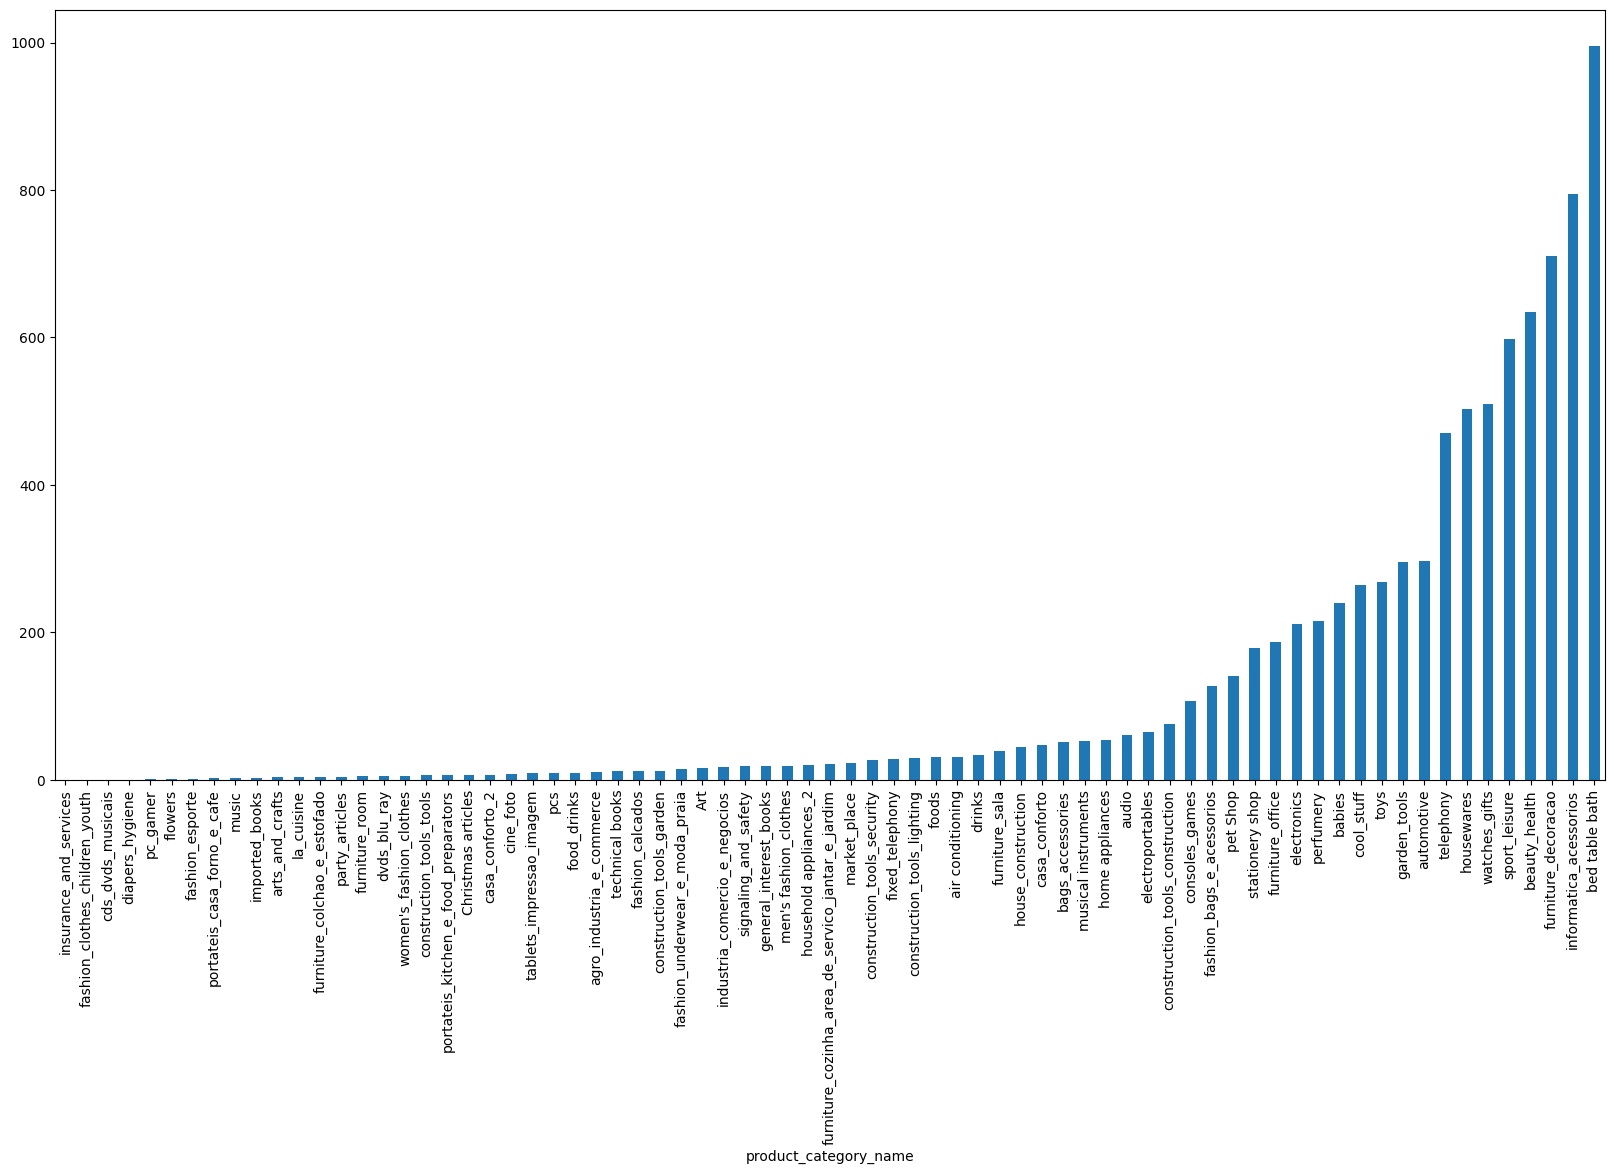

In [32]:
bad_words_toanalyze.groupby(['product_category_name']).sum().sum(axis=1).sort_values().plot(kind='bar', figsize=(20,10))

#### Bar chart of negative comments in product reviews (unit product)

<Axes: xlabel='product_category_name'>

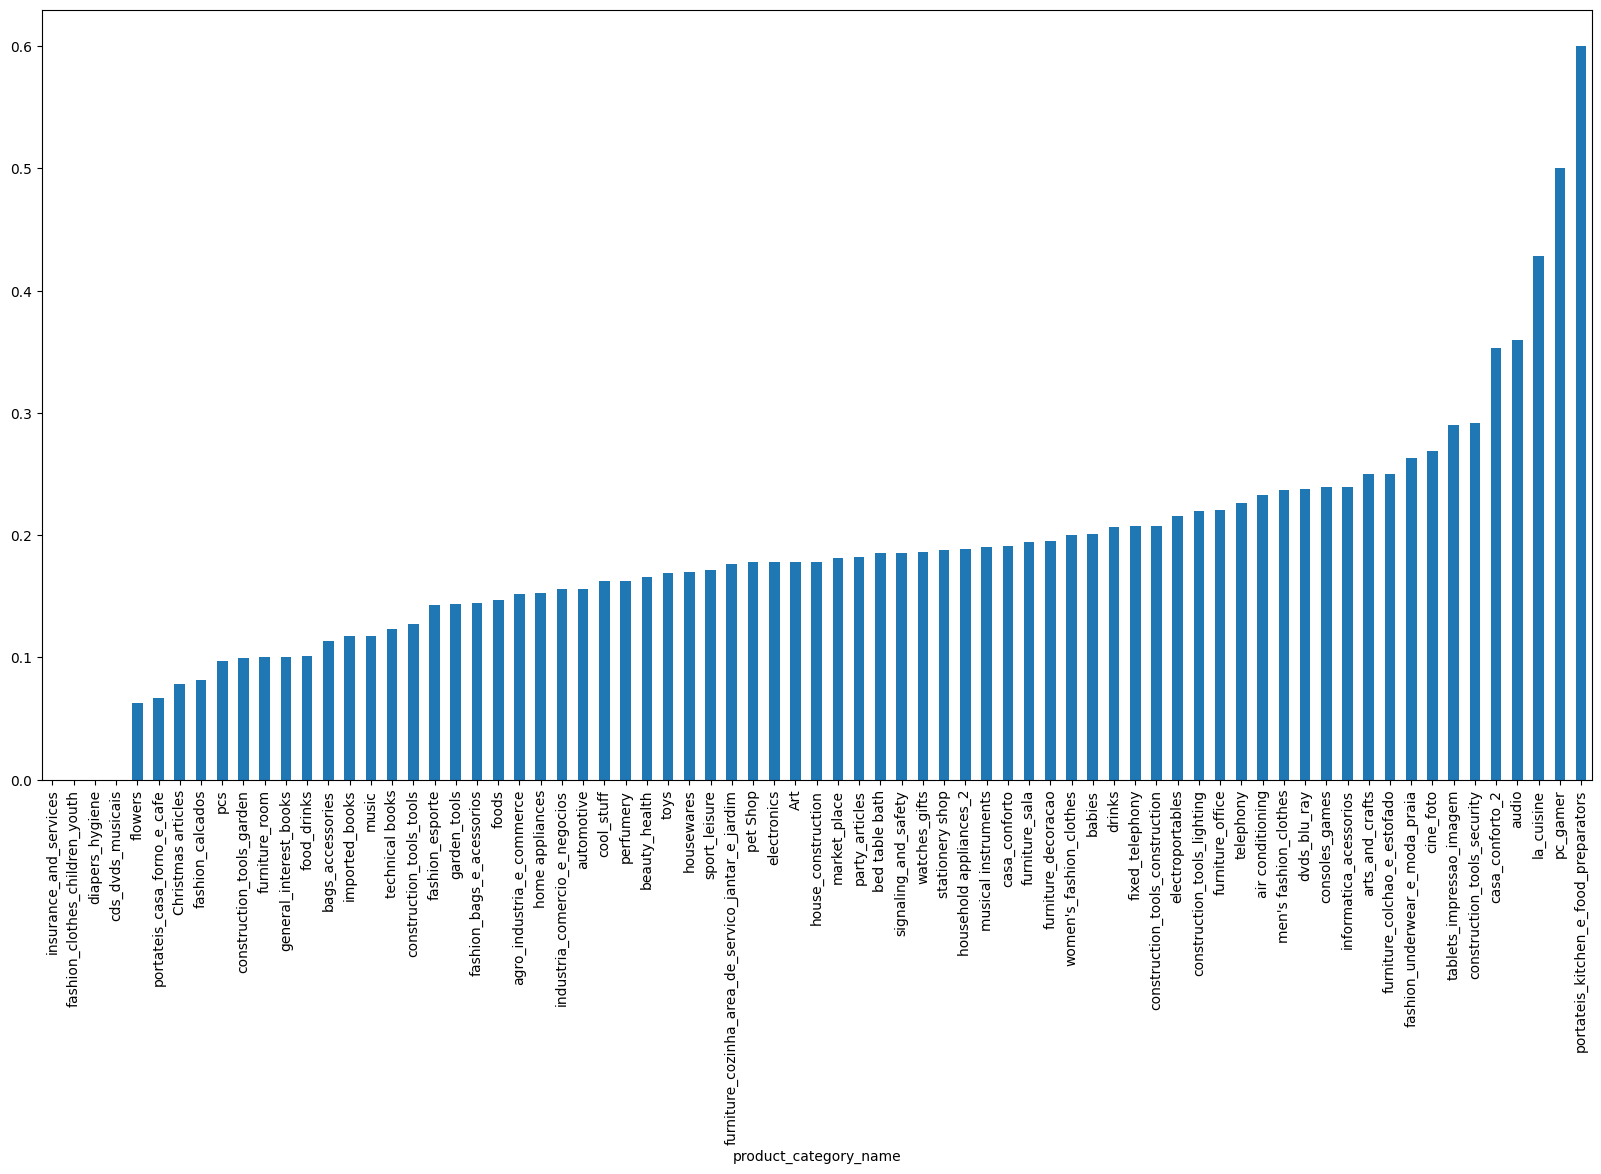

In [33]:
((bad_words_toanalyze.groupby(['product_category_name']).sum().sum(axis=1))/(bad_words_toanalyze['product_category_name'].value_counts())).sort_values().plot(kind='bar', figsize=(20,10))

#### Analysis of the highest negative review rate per unit product

In [34]:
bad_words_toanalyze.groupby(['product_category_name']).sum()[(bad_words_toanalyze.groupby(['product_category_name']).sum()).index=='portateis_kitchen_e_food_preparators']

,terrible,bad,delay,not,defective,late,broken,estimate,slow
product_category_name,,,,,,,,,
portateis_kitchen_e_food_preparators,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0


In [35]:
bad_words_toanalyze.groupby(['product_category_name']).count()[(bad_words_toanalyze.groupby(['product_category_name']).count()).index=='portateis_kitchen_e_food_preparators']

,terrible,bad,delay,not,defective,late,broken,estimate,slow
product_category_name,,,,,,,,,
portateis_kitchen_e_food_preparators,10,10,10,10,10,10,10,10,10


In [36]:
for i in bad_words_products[bad_words_products['product_category_name']=='portateis_kitchen_e_food_preparators']['review_comment_message'].dropna():
    print(i)

the cup is not exactly as it is in the photo despite saying that it is made of semitransparent plastic it is also said that the lid is black and contrary to that the lid is white
great well before the deadline perfect
 excellent
i bought the crystal clear glass and the milky one arrived it works but i didnt like it because it was of inferior quality
unfortunately the main information regarding the product is not clearly found on the lannister page i bought a machine to extract oil with 220 voltage i will return it
good evening the only problem was that the invoice did not show payment for shipping which should have been paid grateful gilson
the invoice was missing which did not arrive with the product and is not in the email which states that it has already been issued and i have not received one at all i am waiting
ive always bought from americascom and orders arrived before the expected date but this one hasnt arrived yet and they havent even sent an email notifying me of anything
pr